In [5]:
from functools import partial, reduce
from typing import TypedDict, Optional
from collections import ChainMap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
from IPython.display import HTML
import trimesh

from problem import mesh, get_transformed_scene, raytrace_silhouette, stochastic_jacaard_index

Introduction

Problem statement: Focus on oncovering practical limitations and exploration of capabilities of SPSA, CRN, and FDSA in the context of an example sim problem. 

Demonstrate methods for dealing with the limitations, and a proper solution. 

Introduce the simulation problem and describe how its a thing - details in section 3 though.

Background

Describe the SPSA algorithm, and its components. Same with other stuff.

Simulation Problem

Describe the simulation, write out the equations for it, etc.,

3.2 Metric

3.3 Experiment

First Attempt

Attempting to perform SPSA on both translation and rotation
The result: slow and poor convergence

The issues: 
Many local optima, the stochastic nature is kind of nice in not necessarily getting stuck but the capability of the 

Show the picture of the bunny

Show the silhouette and then show the raytracing method for stochastic method and describe stochastic jacaards index

In [27]:
def show_sil(o_sil):
    sil = np.array(o_sil)
    sil += 1
    sil[sil == 2] = 0
    sil[sil == 3] = 2
    plt.imshow(np.rot90(sil), cmap="seismic")

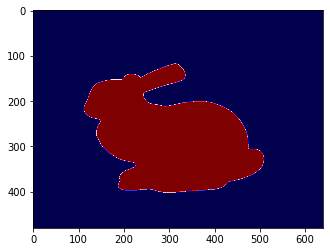

In [24]:
# mesh.show()
sil = raytrace_silhouette(get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*[0, 0, 0]), [0, 0, 0]), perc=1.0)
sil += 1
sil[sil == 2] = 0
sil[sil == 3] = 2
plt.imshow(np.rot90(sil), cmap="seismic")


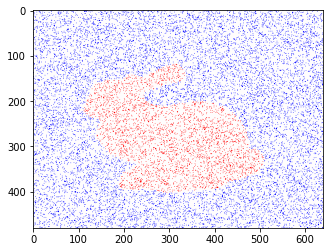

In [26]:
sil = raytrace_silhouette(get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*[0, 0, 0]), [0, 0, 0]), perc=.05)
sil += 1
sil[sil == 2] = 0
sil[sil == 3] = 2
plt.imshow(np.rot90(sil), cmap="seismic")

Describe the setup for finding the true location, theta is rotation + translation

Show the true setp and the perturbation 
Show the average loss after 100 iterations

Show for different levels of raytracing completion

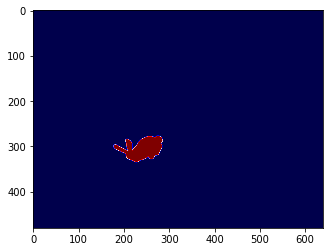

In [28]:
true_rotation = np.array([1, 0, 1])  # np.random.rand(3) * 2 * np.pi
true_translation = np.array([1, 1, 5])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*true_rotation), true_translation)
true_sil = raytrace_silhouette(scene, perc=1)

show_sil(true_sil)

# scene.show()

0.21604486710558402


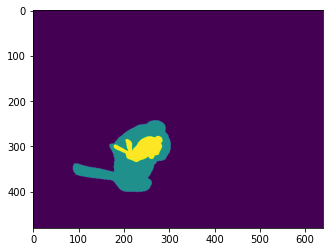

In [34]:
# for initial perturbation, do spsa... 

rotation = true_rotation + np.array([.6, .1, .2])
translation = true_translation + np.array([-.5, -.5, -4])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)
sil = raytrace_silhouette(scene, perc=1)

print(stochastic_jacaard_index(true_sil, sil))
  
plt.imshow(np.rot90(sil + true_sil))

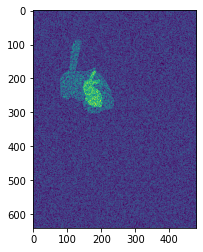

In [66]:
def get_scene_from_theta(theta: np.ndarray):
    # theta is rotation matrix, and translation matrix
    rotation = theta[:3]
    translation = theta[3:]
    rotation_matrix = trimesh.transformations.euler_matrix(*rotation)
    return get_transformed_scene(mesh, rotation_matrix, translation)

def get_loss_from_sil(sil):
    js = stochastic_jacaard_index(true_sil, sil)
    js = np.clip(js, 0.00001, 0.99999)
    return - np.log(js)
    log_odds = np.log(1 - js) - np.log(js)
    return log_odds

def get_loss_from_theta(theta: np.ndarray, perc=0.5, v=None):
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=perc, inds=v)
    return get_loss_from_sil(sil)

def v_generator(perc=0.5):
    return np.random.choice(640 * 480, int(640 * 480 * perc), False)

theta_0 = np.append(rotation, translation)

scene = get_scene_from_theta(theta_0)
sil = raytrace_silhouette(scene, perc=0.5)
plt.imshow(sil + true_sil)

# get_loss_from_theta(np.append(true_rotation, true_translation))


First chart plot:

Do 

In [89]:
from spsa import OptimSPSA

goal_theta = np.append(true_rotation, true_translation)

def experiment(perc):
    optim = OptimSPSA(theta_0, partial(get_loss_from_theta, perc=perc), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=1)
    optim.calibrate()
    optim.run(print_progress=False)
    diffs = optim.thetas - goal_theta
    rms_dist = np.sqrt(np.mean(diffs*diffs,axis=1))
    return optim._loss_history, rms_dist

losses = []
rms_dists = []
for i in range(3):
    i_loss, i_dist = experiment(0.5)
    losses.append(i_loss)
    rms_dists.append(i_dist)

losses = np.array(losses)
rms_dists = np.array(rms_dists)

In [55]:

optim = OptimSPSA(theta_0, partial(get_loss_from_theta, perc=0.1), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=1)
optim.calibrate(True)
optim.run(print_progress=False)

After calibration:  {'gamma': 0.101, 'alpha': 1.5, 't0': 0.5, 'num_approx': 1, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.12270999025501611, 'A': 13.0, 'a0': 5.622492967746638}


array([2.06001305, 0.3042317 , 1.21676139, 0.58771454, 0.64923729,
       2.07362019])

In [70]:
np.save("losses_p5_2", losses)

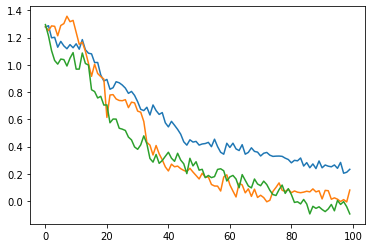

In [73]:
# losses = np.load("losses_p5.npy")
# losses is -np.log(js), if I do np.log(1 - np.exp(-losses)) - losses
log_odds = np.log(1 - np.exp(-losses)) + losses
plt.plot(log_odds)

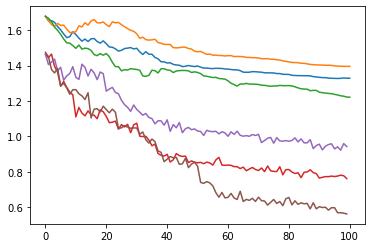

In [94]:
plt.plot(rms_dists.T)
plt.plot(losses.T)

I also want to test with segmented uniform... 

For = 1 I had to change c0 to be higher but otherwise I have c_guess of 0.01


In [75]:
goal_theta = np.append(true_rotation, true_translation)

In [88]:
diffs = optim.thetas - goal_theta

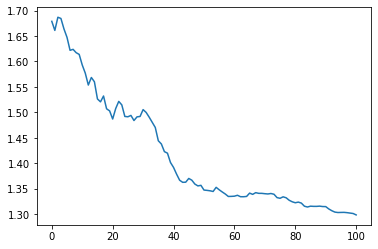

In [87]:
plt.plot(np.sqrt(np.mean(diffs*diffs,axis=1)))